In [1]:
import pandas as pd
import numpy as np

import os.path, time
import yaml
from datetime import date

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
##import seaborn as sns

##sns.set_style("darkgrid")

path = os.path.join(os.getcwd(), 'data/')
plot_dir = os.path.join(os.getcwd(), 'plots/')

pd.set_option('max_columns', 400)
pd.set_option('max_rows', 400)

from sklearn.externals import joblib

from cce_utils.query_to_pandas import QuerytoDataFrame
from cce_utils.get_query import get_query
from cce_utils.start_logging import start_logging
start_logging()

import logging
logger = logging.getLogger('main')

In [2]:
# load model
filename_model = "model\signup_model_60.joblib.dat"
filename_model_columns = "model\signup_model_60_columns.joblib.dat"
filename_model_imputer = "model\signup_model_60_imputer.joblib.dat"

In [3]:
# load model
model = joblib.load(filename_model)
X_columns = joblib.load(filename_model_columns)
imputer = joblib.load(filename_model_imputer)

In [4]:
def _define_query_chunks(raw_query, r_low, r_high):
    query = raw_query.format(r_low=r_low, r_high=r_high)
    return query

In [5]:
def _get_data(r_low, r_high):
    logger.info("Running _get_data")
    raw_query = "select m.*, mm.statecode from modeling.scoringtable_20170519 m join modeling.scoringtable_201705 mm on m.voterbase_id=mm.voterbase_id where m.rowid between {r_low} and {r_high};"
    query = _define_query_chunks(raw_query=raw_query, r_low=r_low, r_high=r_high)
    df = QuerytoDataFrame(query=query, database="Redshift").df
    df = df.set_index('voterbase_id')
    df = df.rename(columns={'statecode_dc':'statecode_DC','statecode_il':'statecode_IL','statecode_md':'statecode_MD','statecode_ma':'statecode_MA','statecode_ny':'statecode_NY','statecode_nj':'statecode_NJ','statecode_oh':'statecode_OH','statecode_pa':'statecode_PA'})
    return df

In [6]:
df = _get_data(r_low=0, r_high=100000)
print df.shape
df.head()

(100000, 474)


,legal_commercial_model_usage_ok,head_hh_flag,hh_count,coalesced_commercial_age,coalesced_commercial_age2,coalesced_commercial_age3,coalesced_commercial_age_is_modeled,age_18_34_commercial,age_35_49_commercial,age_50_64_commercial,age_65_plus_commercial,hh_avg_commercial_age,race_afam_commercial,race_hispanic_commercial,race_asian_commercial,race_white_commercial,race_native_commercial,hh_all_afam_commercial,hh_all_hispanic_commercial,hh_all_asian_commercial,hh_all_white_commercial,hh_all_native_commercial,gender_score,gender_score_is_modeled,hh_gender_score,vb_phone_presence,vb_phone_listed,vb_phone_unlisted,vb_email_presence,vb_email_append_ind,vb_email_append_hh,vb_deceased,married,unmarried,children_in_hh,num_children_in_hh,young_children_in_hh,teenage_children_in_hh,education_highschool,education_collegegrad,num_in_hh,vehicleowner,likelihood_to_purchase_vehicle_in_6mos,homeowner,property_type_singlefamily,property_type_multifamily,address_type_firm,address_type_general_delivery,address_type_high_rise,address_type_po_box,address_type_rural,address_type_street,has_ncoa_return_code,length_of_residence,length_of_residence_is_null,home_sqft,home_sqft_is_null,home_total_value,home_total_value_is_unknown,log_home_value_bucket,home_value_is_null,home_purchase_year,home_purchase_year_is_null,log_household_net_worth_bucket,household_net_worth_is_null,head_hh_salary_amt,head_hh_salary_amt_is_null,log_household_income_bucket,household_income_is_null,donor_charity,donor_enviro_causes,hh_donor_charity_pctile,hh_donor_charity,hh_donor_enviro_causes,dog_enthusiast,cat_enthusiast,pet_enthusiast,travel_domestic_foreign,license_hunt_fish,religious_purchase,political_purchase,health_institution_purchase,general_purchase,hh_license_hunt_fish,hh_religious_purchase,hh_political_purchase,hh_health_institution_purchase,hh_general_purchase,presence_of_cell_phone,presence_of_cell_phone_modeled,hh_has_credit_card,online_is_online,online_facebook,online_purchaser,hh_online_social_network_twentile,hh_online_is_online,hh_online_facebook,employed,employed_unknown,retired,hh_business_owner,emp_nurse,emp_beauty,emp_self_employed,emp_healthcare,emp_realestate,emp_educator,emp_military,hh_emp_active_military,hh_emp_active_military_modeled,hh_emp_inactive_military,hh_emp_inactive_military_modeled,hh_employed,hh_retired,hh_emp_nurse,hh_emp_beauty,hh_emp_healthcare,hh_emp_realestate,hh_emp_educator,ts_zip5_pct_catholic,ts_zip5_pct_jewish,protestant,catholic,christian_orthodox,jewish,mormon,buddhist_shinto,hindu,muslim,sikh,census10_county_is_in_msa,census10_is_in_place,census10_place_is_in_principal_city,census10_pct_male,census10_pct_under18,census10_pct_18plus,census10_pct_18to34,census10_pct_35to64,census10_pct_65plus,census10_pct_race5way_hispanic,census10_pct_race5way_black,census10_pct_race5way_asian,census10_pct_race5way_white,census10_pct_race5way_native,census10_total_hh,census10_pct_hh_owned_with_loan,census10_pct_hh_owned_no_loan,census10_pct_hh_renter,census10_pct_hh_single_family_head,census10_pct_hh_with_own_children_under18,census10_pct_hh_1_person,census10_pct_hh_husband_wife_family,census10_total_pop,log_census10_pop_density,log_census10_total_hispanic_density,log_census10_total_white_density,log_census10_total_black_density,log_census10_total_native_american_density,log_census10_total_asian_density,census10_total_hawaiian_pac_islander_pct,log_census10_total_hawaiian_pac_islander_density,census10_total_other_race_pct,log_census10_total_other_race_density,census10_total_multi_race_pct,log_census10_total_multi_race_density,census10_adult_pct,log_census10_adult_density,census10_adult_hispanic_pct,log_census10_adult_hispanic_density,census10_adult_white_pct,log_census10_adult_white_density,census10_adult_black_pct,log_census10_adult_black_density,census10_adult_native_american_pct,log_census10_adult_native_american_density,census10_adult_asian_pct,log_census10_adult_asian_density,census10_adult_hawaiian_pac_islander_pct,log_census10_adult_hawaiian

In [7]:
def _make_predictions(df):
    logger.info("Running _make_predictions")
       
    # make predictions
    ## This actually subsets to just the columns needed to train the model
    X_pred = df[X_columns].copy()

    X_pred = imputer.transform(X_pred)

    df['pred_mailscore'] = model.predict_proba(X_pred)[:,1]

    return df[['pred_mailscore']]

In [8]:
#df = pd.get_dummies(data=df, columns=['statecode'])

dt = df.dtypes
str_cols = dt[dt == 'object'].index
str_cols

Index([u'ienrollmentnumlen', u'marketshare', u'ln_marketshare', u'avg_ptc',
       u'ln_ptc', u'sq_ptc', u'ratespread', u'statecode'],
      dtype='object')

In [9]:
for col in str_cols:
    df[col] = pd.to_numeric(df[col],errors='coerce')

In [10]:
df.head()

,legal_commercial_model_usage_ok,head_hh_flag,hh_count,coalesced_commercial_age,coalesced_commercial_age2,coalesced_commercial_age3,coalesced_commercial_age_is_modeled,age_18_34_commercial,age_35_49_commercial,age_50_64_commercial,age_65_plus_commercial,hh_avg_commercial_age,race_afam_commercial,race_hispanic_commercial,race_asian_commercial,race_white_commercial,race_native_commercial,hh_all_afam_commercial,hh_all_hispanic_commercial,hh_all_asian_commercial,hh_all_white_commercial,hh_all_native_commercial,gender_score,gender_score_is_modeled,hh_gender_score,vb_phone_presence,vb_phone_listed,vb_phone_unlisted,vb_email_presence,vb_email_append_ind,vb_email_append_hh,vb_deceased,married,unmarried,children_in_hh,num_children_in_hh,young_children_in_hh,teenage_children_in_hh,education_highschool,education_collegegrad,num_in_hh,vehicleowner,likelihood_to_purchase_vehicle_in_6mos,homeowner,property_type_singlefamily,property_type_multifamily,address_type_firm,address_type_general_delivery,address_type_high_rise,address_type_po_box,address_type_rural,address_type_street,has_ncoa_return_code,length_of_residence,length_of_residence_is_null,home_sqft,home_sqft_is_null,home_total_value,home_total_value_is_unknown,log_home_value_bucket,home_value_is_null,home_purchase_year,home_purchase_year_is_null,log_household_net_worth_bucket,household_net_worth_is_null,head_hh_salary_amt,head_hh_salary_amt_is_null,log_household_income_bucket,household_income_is_null,donor_charity,donor_enviro_causes,hh_donor_charity_pctile,hh_donor_charity,hh_donor_enviro_causes,dog_enthusiast,cat_enthusiast,pet_enthusiast,travel_domestic_foreign,license_hunt_fish,religious_purchase,political_purchase,health_institution_purchase,general_purchase,hh_license_hunt_fish,hh_religious_purchase,hh_political_purchase,hh_health_institution_purchase,hh_general_purchase,presence_of_cell_phone,presence_of_cell_phone_modeled,hh_has_credit_card,online_is_online,online_facebook,online_purchaser,hh_online_social_network_twentile,hh_online_is_online,hh_online_facebook,employed,employed_unknown,retired,hh_business_owner,emp_nurse,emp_beauty,emp_self_employed,emp_healthcare,emp_realestate,emp_educator,emp_military,hh_emp_active_military,hh_emp_active_military_modeled,hh_emp_inactive_military,hh_emp_inactive_military_modeled,hh_employed,hh_retired,hh_emp_nurse,hh_emp_beauty,hh_emp_healthcare,hh_emp_realestate,hh_emp_educator,ts_zip5_pct_catholic,ts_zip5_pct_jewish,protestant,catholic,christian_orthodox,jewish,mormon,buddhist_shinto,hindu,muslim,sikh,census10_county_is_in_msa,census10_is_in_place,census10_place_is_in_principal_city,census10_pct_male,census10_pct_under18,census10_pct_18plus,census10_pct_18to34,census10_pct_35to64,census10_pct_65plus,census10_pct_race5way_hispanic,census10_pct_race5way_black,census10_pct_race5way_asian,census10_pct_race5way_white,census10_pct_race5way_native,census10_total_hh,census10_pct_hh_owned_with_loan,census10_pct_hh_owned_no_loan,census10_pct_hh_renter,census10_pct_hh_single_family_head,census10_pct_hh_with_own_children_under18,census10_pct_hh_1_person,census10_pct_hh_husband_wife_family,census10_total_pop,log_census10_pop_density,log_census10_total_hispanic_density,log_census10_total_white_density,log_census10_total_black_density,log_census10_total_native_american_density,log_census10_total_asian_density,census10_total_hawaiian_pac_islander_pct,log_census10_total_hawaiian_pac_islander_density,census10_total_other_race_pct,log_census10_total_other_race_density,census10_total_multi_race_pct,log_census10_total_multi_race_density,census10_adult_pct,log_census10_adult_density,census10_adult_hispanic_pct,log_census10_adult_hispanic_density,census10_adult_white_pct,log_census10_adult_white_density,census10_adult_black_pct,log_census10_adult_black_density,census10_adult_native_american_pct,log_census10_adult_native_american_density,census10_adult_asian_pct,log_census10_adult_asian_density,census10_adult_hawaiian_pac_islander_pct,log_census10_adult_hawaiian

In [11]:
out = _make_predictions(df)
out.head()

,pred_mailscore
voterbase_id,
AL-1848347,0.122379
AZ-5821187,0.243390
CA-000011376745,0.287977
CA-19565161,0.112796
CA-27828042,0.215529


In [12]:
out['pred_mailscore'].describe()

count    100000.000000
mean          0.204550
std           0.105294
min           0.026838
25%           0.133890
50%           0.180833
75%           0.244090
max           0.785969
Name: pred_mailscore, dtype: float64

In [13]:
model.classes_

array([0, 1], dtype=int64)

In [19]:
#df = df.rename(columns={'statecode_dc':'statecode_DC','statecode_il':'statecode_IL','statecode_md':'statecode_MD','statecode_ma':'statecode_MA','statecode_ny':'statecode_NY','statecode_nj':'statecode_NJ','statecode_oh':'statecode_OH','statecode_pa':'statecode_PA'})
#df = df.rename(columns={'statecode_il':'statecode_IL'})
#df = df.rename(columns={'statecode_md':'statecode_MD'})
#df = df.rename(columns={'statecode_ma':'statecode_MA'})
#df = df.rename(columns={'statecode_ny':'statecode_NY'})
#df = df.rename(columns={'statecode_nj':'statecode_NJ'})
#df = df.rename(columns={'statecode_oh':'statecode_OH'})
#df = df.rename(columns={'statecode_pa':'statecode_PA'})

# Okay, so for next time: The code in the cell above has to be run instead of the dummies. That's because I get to sections of the file where there is only one state so it doesn't generate dummies equally, it only generates one state worth of dummies and the code breaks. So it's better to just rename them. 

In [14]:
##okay, the stuff above was troubleshooting for the error I got. Consider loggin the errors so that I can see how I figured stuff out
def _run_chunk(r_low, r_high):
    logger.info("Running _run_chunk for rows {r_low} to {r_high}".format(r_low=r_low, r_high=r_high))
    
    df = _get_data(r_low, r_high)
    #df = pd.get_dummies(data=df, columns=['statecode'])

    dt = df.dtypes
    str_cols = dt[dt == 'object'].index
    str_cols
    
    for col in str_cols:
        df[col] = pd.to_numeric(df[col],errors='coerce')
    
    if len(df) > 0:
        out = _make_predictions(df)
        return out
    else:
        logger.info("There were no observations in rows {r_low} to {r_high}".format(r_low=r_low, r_high=r_high))
        return None

In [15]:
t00 = time.time()

bottom = 5800001
top = 100000000
step = 200000

r_low = bottom
r_high = bottom + step
for i in range(0, (top - bottom)/step):
    cust = _run_chunk(r_low=r_low, r_high=r_high)
    if cust is None:
        logger.info("Ending early because there are no additional rows in the table")
        break
    if i == 0:
        cust_out = cust.copy()
    else:
        cust_out = cust_out.append(cust)
    r_low = r_high + 1
    r_high += step
    
t11 = time.time()
logger.info("Time to run rows {bottom} to {top}: {m} minutes".format(bottom=bottom, top=top, m=(t11 - t00)/60))

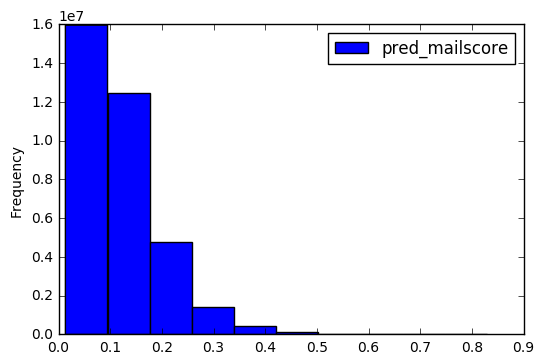

In [16]:
cust_out.to_csv('D:\code\python-data\signup_model\signup_predictions_{}.csv'.format(date.today()))

cust_out.describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

cust_out.plot(kind='hist')

In [17]:
print cust_out.shape
print cust_out.dtypes
cust_out.head()

(35202106, 1)
pred_mailscore    float64
dtype: object


,pred_mailscore
voterbase_id,
IL-Y29454059487273,0.099835
IL-Y29454064467413,0.240452
IL-Y29454092060416,0.160421
IL-Y29454090292995,0.129120
IL-Y29454058659056,0.062546
